In [43]:
"""
SANEEYA SANDEEP VICHARE
BF550
"""


'\nSANEEYA SANDEEP VICHARE\nU75237907\n\nPROJECT 2 - BF550\n'

In [ ]:
"""
The research paper titled "Identification of potential biomarkers with colorectal cancer based on bioinformatics analysis and machine learning" was
chosen. The figures 2B and 2C were recreated using normalized data obtained from GEO (Accession: GSE103512). 

Counts data can be found at : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE103512 
Affymetrix platform data for probe-mapping can be found at : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL13158

This paper was chosen in collaboration with Rutu Kothari of BF550.
"""

In [45]:
"""
Cleaning and probe-mapping of counts data

The 'raw' data obtained was already normalized. The following code performs probe-mapping where the Probe IDs are matched with their respective Gene 
symbols. Since multiple Probe IDs can coresspond to a single gene symbol, a mean count value for such probes will be calculated in the following code. 

Finally the resulting file will be a modified and processed counts data that can then be merged with metadata before Differential Gene Expression 
Analysis. 
"""

import pandas as pd
import numpy as np

# Read the files
counts_df = pd.read_csv('raw_counts.csv', index_col='ProbeID') # indexing each row by respective Probe ID
gene_id_df = pd.read_csv('probe_to_gene.csv') # this is the Affymetrix Array plate file, consists of Gene IDs corresponding to Probe IDs

# Drop the GB_ACC column from gene_id_df
gene_id_df = gene_id_df.drop('GB_ACC', axis=1) # Removing the Gene Accession number column for better processing

# Merge the counts with gene_id data
# the gene ids are matched to their respective to Probe IDs and the two files are merged 
merged_df = pd.merge(gene_id_df, counts_df, left_on='ProbeID', right_index=True, how='inner')

# Group by GeneSymbol and calculate mean for each sample
# Here we group the rows by Gene Symbol and then calculate the mean counts value for a gene with multiple probes
# {if x.dtype.kind in 'biufc'} >>> x coressponds to a column, this code checks the data type of elements in column x
# "bifuc" means boolean, integer, unassigned integer, floating-point, complex number
# thus, if the values are numeric (count), its mean is calculated and assigned to the gene symbol
result_df = merged_df.groupby('Gene Symbol').agg(lambda x: x.mean() if x.dtype.kind in 'biufc' else x.iloc[0])

# Then we reset index to make GeneSymbol a column
result_df = result_df.reset_index()

# Reordering columns for aesthetics
columns = ['ENTREZ_GENE_ID', 'Gene Symbol'] + [col for col in result_df.columns if col not in ['ENTREZ_GENE_ID', 'Gene Symbol']]
result_df = result_df[columns]

# Save the result to a new CSV file
result_df.to_csv('processed_counts.csv', index=False)

print("Processing complete. Output saved as 'processed_counts.csv'")

Processing complete. Output saved as 'processed_counts.csv'


In [46]:
# Next we have to merge our counts data with the metadata to classify our samples between Tumor and Normal samples
# This will be followed by Differential Gene Expression Analysis
# Multiple checkpoints have been added to this part of the code for the sake of avoiding or catching any errors

metadata = pd.read_csv("metadata.csv")  # Loading metadata
metadata

counts = pd.read_csv("processed_counts.csv") # Loading the processed counts data
counts

# First we filter columns with expression data
# Depending on the order of columns we had decided in the previous cell (ENTREZ ID, Gene symbol, Probe ID, Sample IDs)
# Thus, we extract only the columns containing the samples, starting from the 4th column (here starting from 3 becausse python indexes from 0)
expression_data = counts.iloc[:, 3:]
expression_data.columns = metadata['SampleID'] # replacing the column names with SampleID from the metadata
print("Expression Data Shape:", expression_data.shape)
print(expression_data) # Checkpoint 1

# Then we import libraries for performing the t-test
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np

metadata.set_index("SampleID", inplace=True) # for the sake of easier alignment with the espression data, we have set the Sample IDs as the index

# Re-checking alignment to avoid errors
print("Metadata Sample IDs:\n", metadata.index.tolist()) # Checkpoint 2

# Extract tumor and normal sample IDs
tumor_samples = metadata[metadata["Sample_Type"] == "Tumor"].index.tolist()
normal_samples = metadata[metadata["Sample_Type"] == "Normal"].index.tolist()

# Next we have to separate the samples according to their condition
# Both the conditions are stored in different lists 
# Confirming the extracted IDs
print("Tumor Sample IDs:\n", tumor_samples)  # Checkpoint 3
print("Normal Sample IDs:\n", normal_samples)

# Re-checking alignment
print("Metadata Sample IDs:\n", metadata.index.tolist()) # Checkpoint 4



"""Then we start with the Differential Gene Expression Analysis"""


# First we calculate log2 fold-change
# The logic involves taking mean expression of each gene across tumor samples and subtracts the mean expression across normal samples
log2fc = expression_data[tumor_samples].mean(axis=1) - expression_data[normal_samples].mean(axis=1)
print("Log2 Fold Change (First 5):\n", log2fc.head()) # Checkpoint 5

# Then we perform t-tests for each gene (row) comparing tumor vs. normal samples
# here, the lambda function performs two functions:
    # 1. it takes one row of expression data (one gene across all samples)
    # 2. computes the p-value for the difference in means between tumor and normal samples using {ttest_ind}
p_values = expression_data.apply(
    lambda row: ttest_ind(row[tumor_samples], row[normal_samples], equal_var=False).pvalue, axis=1
)
print("P-Values (First 5):\n", p_values.head()) # Checkpoint 6

# Then we adjust p-values using Benjamini-Hochberg False Discovery Rate method to account for multiple comparisons
# The {multipletests(p_values, method='fdr_bh')} >> adjusts p-values for multiple testing
# {multipletests()} returns a tuple with 4 values:
    # 1. Boolean array that determines whether the null hypothesis is being rejected, here it is not used, hence (_)
    # 2. Adjusted p-values (here, {adj_p_values})
    # 3. critical values (threshold of p-values for significance) >> here it is not used, hence (_)
    # 4. Significance level, here not used, hence (_) 
_, adj_p_values, _, _ = multipletests(p_values, method='fdr_bh')
print("Adjusted P-Values (First 5):\n", adj_p_values[:5]) # Checkpoint 7


# Then we compile the reults while also adding the gene symbol value 
results = pd.DataFrame({
    'Gene Symbol': counts['Gene Symbol'],
    'Log2FC': log2fc,
    'P-value': p_values,
    'Adjusted P-value': adj_p_values
})
print("Results (First 5 Rows):\n", results.head())  # Checkpoint 8


Expression Data Shape: (20741, 69)
SampleID  GSM2772735  GSM2772736  GSM2772737  GSM2772738  GSM2772739  \
0           4.941464    4.812936    5.072617    5.335109    5.035711   
1           4.085727    5.018430    4.302958    5.905031    6.157662   
2           4.460969    4.267660    4.540349    4.730692    4.651456   
3           4.920331    4.914272    5.312942    5.240750    5.528408   
4           7.004786    7.640159    7.200231    6.952686    6.595899   
...              ...         ...         ...         ...         ...   
20736       8.083036    7.690509    8.105455    7.820598    8.155863   
20737       5.139227    5.633901    5.492238    5.507106    5.470961   
20738       5.273864    4.703412    4.472804    5.371402    4.735967   
20739       3.042762    2.904998    3.124767    3.120964    2.908321   
20740       3.495876    3.444822    3.762520    3.902147    3.675133   

SampleID  GSM2772740  GSM2772741  GSM2772742  GSM2772743  GSM2772744  ...  \
0           4.559996   

Significance Counts:
 Significance
Not Significant    20637
Downregulated         87
Upregulated           17
Name: count, dtype: int64
Results saved to 'DEG_analysis_results.csv'.


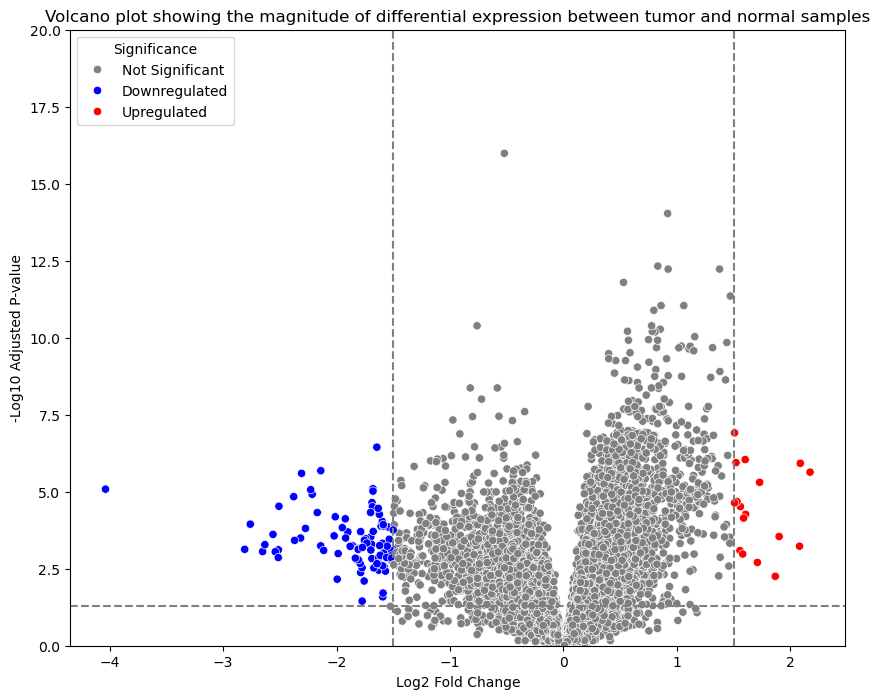

In [47]:
# Next we will extract differentially expressed genes on the basis of their significance and then plot Figure 2C

import matplotlib.pyplot as plt
import seaborn as sns

# We will define the same thresholds as those mentioned in the paper
fc_threshold = 1.5
pval_threshold = 0.05

# We will then classify genes as:
    # Upregulated: log2FC > threshold and adjusted p-value < threshold
    # Downregulated: log2FC < -threshold and adjusted p-value < threshold
    # Otherwise: Not Significant
results['Significance'] = 'Not Significant'
results.loc[(results['Log2FC'] > fc_threshold) & (results['Adjusted P-value'] < pval_threshold), 'Significance'] = 'Upregulated'
results.loc[(results['Log2FC'] < -fc_threshold) & (results['Adjusted P-value'] < pval_threshold), 'Significance'] = 'Downregulated'

print("Significance Counts:\n", results['Significance'].value_counts())
results.to_csv("DEG_analysis_results.csv", index=False) # saving the expression data
print("Results saved to 'DEG_analysis_results.csv'.")



# Then we plot the Volcano plot (Figure 2C) showing the magnitude of differential expression between tumor and normal samples. 
plt.figure(figsize=(10, 8))
sns.scatterplot(data=results, x='Log2FC', y=-np.log10(results['Adjusted P-value']),
                hue='Significance', palette={'Upregulated': 'red', 'Downregulated': 'blue', 'Not Significant': 'gray'})
plt.axvline(fc_threshold, color='grey', linestyle='--')
plt.axvline(-fc_threshold, color='grey', linestyle='--')
plt.axhline(-np.log10(pval_threshold), color='grey', linestyle='--')

# I have only set the y-axis limit here to make sure the image produced is same as the one in the paper, however it works without setting the limit too
plt.ylim(0, 20)

plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-value')
plt.title('Volcano plot showing the magnitude of differential expression between tumor and normal samples')
plt.savefig("volcano_plot.png")  # Saving a copy of the plot
plt.show()

Significant Genes (First 5):
 196       ACTG2
257    ADAMDEC1
258     ADAMTS1
312       ADH1C
371         AG2
Name: Gene Symbol, dtype: object
Expression Data Index (First 5):
 Index(['A1BG', 'A1CF', 'A2BP1', 'A2LD1', 'A2M'], dtype='object', name='Gene Symbol')
Number of common genes: 104
Heatmap Data Shape: (104, 69)


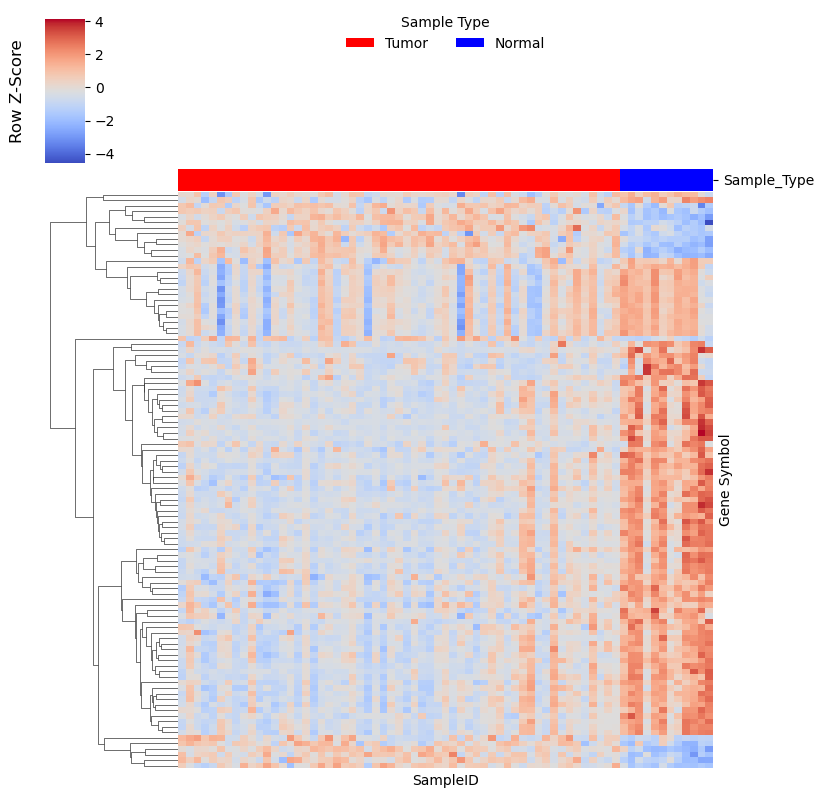

In [48]:
""" Next, we make the heatmap in Figure 2B"""
# This part of our code extracts necessary elements of our DEG analysis ande plots the heatmap
# The authors have used 'Heatmapper' for making Figure 2B, we have thus replicated the conditions of Heatmapper particularly used for that figure

# Here I was just ensuring the index of expression_data matches the gene symbols in counts to avoid errors, another checkpoint
expression_data.index = counts['Gene Symbol']

# Then we identify and extract the Gene IDs of significant genes (we have used the author defined thresholds again)
significant_genes = results[
    (results['Adjusted P-value'] < pval_threshold) & 
    (results['Log2FC'].abs() > fc_threshold)
]
significant_gene_symbols = significant_genes['Gene Symbol']

# Checking alignment between significant_gene_symbols and expression_data index
print("Significant Genes (First 5):\n", significant_gene_symbols.head()) # Checkpoint 9
print("Expression Data Index (First 5):\n", expression_data.index[:5])

# Then we filter for "common genes" between the significant gene list and the expression_data
common_genes = significant_gene_symbols[significant_gene_symbols.isin(expression_data.index)]
print(f"Number of common genes: {len(common_genes)}")  # Debugging alignment
# Then we subset expression data for just the significant/common genes
heatmap_data = expression_data.loc[common_genes]
print("Heatmap Data Shape:", heatmap_data.shape) # Checkpoint 10

# To match the alignment of the heatmap in the paper, we have to reorder columns: Tumor samples first, then Normal samples
ordered_columns = tumor_samples + normal_samples
heatmap_data = heatmap_data[ordered_columns]

# To ensure comparable scales across genes for the heatmap , we have to do Z-score normalization across rows (genes)
# This centers each gene's expression values around 0 with a standard deviation of 1
from scipy.stats import zscore
heatmap_data_normalized = heatmap_data.apply(zscore, axis=1)



"""CLUSTERING"""

# The authors have used Euclidean Distance Measuring method and the Average Linkage clustering method through Heatmapper for this Heirarchial Clustering

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

# First we compute the pairwise distances between rows (genes) and columns (samples) in the heatmap_data
# Calculate the Euclidean distance for rows and columns
row_dist = pdist(heatmap_data, metric='euclidean')  # Euclidean distance for rows
col_dist = pdist(heatmap_data.T, metric='euclidean')  # Euclidean distance for columns
# here we transpose the 2D matrix so that columns represent samples and rows represent genes (used for sample clustering)

# Then we perform hierarchical clustering with average linkage
row_linkage = linkage(row_dist, method='average')  # Average linkage for rows
col_linkage = linkage(col_dist, method='average')  # Average linkage for columns
# Here, the distance between clusters is the average distance between all pairs of points in the clusters



# Then we map the two different sample types to two different colors
sample_colors = metadata.loc[heatmap_data.columns, 'Sample_Type'].map({
    'Tumor': 'red',
    'Normal': 'blue'
})

# Next we create a heatmap
g = sns.clustermap(
    heatmap_data_normalized,
    cmap="coolwarm",
    row_cluster=True,  # Only the row or genes are clustered
    col_cluster=False, # samples are kept in the order specified before
    row_linkage=row_linkage,  # Using average linkage for rows
    col_linkage=col_linkage,# again, we keep the same sample order as defined before
    xticklabels=False,  # Removing sample names to avoid cluttering 
    yticklabels=False,  # Removing gene names to avoid cluttering
    row_colors=None,
    col_colors=sample_colors,  # Adding column colors to distinguish between the two sample types
    figsize=(8, 8),  
    cbar_kws={'label': 'Row Z-Score'},  # Colorbar label according to the reference paper
    
)

# Aesthetics of the heatmap

# First we adjust the color bar posiyion, coordinates and label
g.cax.yaxis.set_label_position('left')
g.cax.yaxis.set_label_coords(-0.5, 0.5)  # Adjust label position
g.cax.set_ylabel('Row Z-Score', rotation=90, fontsize=12, labelpad=15)

# To explain the color coding of the sample types, we added a legend for the sample type
for label, color in {'Tumor': 'red', 'Normal': 'blue'}.items():
    g.ax_col_dendrogram.bar(0, 0, color=color, label=label, linewidth=0) # we make sure to keep this bar invisible so as to not spoil the aesthetics
g.ax_col_dendrogram.legend(
    loc='upper center', # places legend above dendogram
    ncol=2, # arranges legend items into 2 columns: Tumor and Normal
    bbox_to_anchor=(0.5, 1.1),
    frameon=False, # to remove the frame of the legend 
    title='Sample Type'
)

# Remove extra spacing between row clusters and the heatmap
g.ax_row_dendrogram.set_visible(True)

plt.savefig("Heatmap.png")
plt.show()